In [1]:
from utils import make_env


env = make_env(max_step=1000, return_full_state=True)

env.reset()
env.render(mode="print")

action = env.action_space.sample()
state, reward, done, info = env.step(action)

pygame 2.1.0 (SDL 2.0.16, Python 3.10.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
life: 	1	score: 	0	fps: 	0
------------
-          -
-          -
-          -
-          -
-          -
-     v    -
-          -
-        F -
-          -
-          -
------------


In [2]:
state

{'direc': array(3),
 'board': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)}

In [3]:
import time


env.reset()
done = False
rewards = 0

frames = 0
start = time.time()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    rewards += reward

    frames += 1

frames // (time.time() - start), rewards

(2065.0, -223.59999999999835)

In [4]:
action_spec = env.action_space
obs_spec = env.observation_space

action_spec, obs_spec

(Discrete(5), Box(0, 4, (10, 10), uint8))

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils


# utils.set_random_seed(42)

direc_inputs = layers.Input(shape=(), dtype="uint8", name="direc")
x = layers.Lambda(lambda input_batch: tf.one_hot(input_batch, depth=4))(direc_inputs)
direc_outputs = layers.Dense(16, activation="relu")(x)

board_inputs = layers.Input(shape=obs_spec.shape, dtype="uint8", name="board")
x = layers.Lambda(lambda input_batch: tf.cast(input_batch, dtype="float32") / 4.)(board_inputs)
x = layers.Flatten()(x)
board_outputs = layers.Dense(128, activation="relu")(x)

x = layers.Concatenate()([direc_outputs, board_outputs])

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
state_values = layers.Dense(1)(x)
raw_advantages = layers.Dense(action_spec.n)(x)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages

model = models.Model(inputs=[direc_inputs, board_inputs], outputs=Q_values)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 10, 10)]     0           []                               
                                                                                                  
 direc (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 10, 10)       0           ['board[0][0]']                  
                                                                                                  
 lambda (Lambda)                (None, 4)            0           ['direc[0][0]']                  
                                                                                              

In [6]:
target = models.clone_model(model)
target.set_weights(model.get_weights())

In [7]:
from tensorflow.keras import optimizers, losses

from collections import deque


n_iterations = 2_000
max_step = 1_500
train_interval = 1
target_soft_update = False
target_update_interval = n_iterations * 0.15 * (0.5 if target_soft_update else 1)

gamma = 0.90 # Discount factor
buffer_size = 500_000 # 1_000_000
fill_buffer_iters = 50 # 100

batch_size = 32
lr = 5e-7
optimizer = optimizers.Adam(learning_rate=lr)
loss_fn = losses.Huber()

epsilon_fn = optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=n_iterations//2,
    end_learning_rate=0.01
)

replay_buffer = deque(maxlen=buffer_size)


params = {
    "iteration": n_iterations,
    "n_step": max_step,
    "batch_size": batch_size,
    "gamma": gamma,
    "warmup": fill_buffer_iters,
    "train_interval": train_interval,
    "target_update_interval": target_update_interval,
    "soft_update": target_soft_update,
    "epsilon_fn": epsilon_fn
}

In [8]:
from dqn_agent import DQNAgent


agent = DQNAgent(
    env=env, model=model, target=target, 
    optimizer=optimizer, loss_fn=loss_fn, 
    replay_buffer=replay_buffer
)

In [9]:
rewards, total_loss = agent.training_loop(**params)

agent.model.save(f"models/Snake DQN ({n_iterations} iters).h5")

Episode: 1999, Steps: 1000, FPS: 113, Reward:-605.1, Epsilon: 0.0100, Loss: 0.587185263633728WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


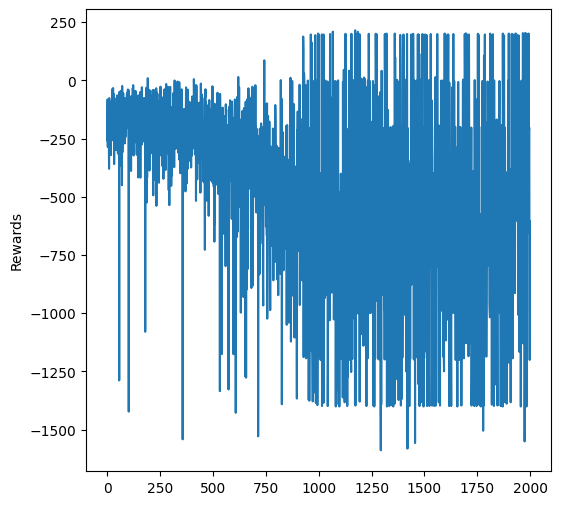

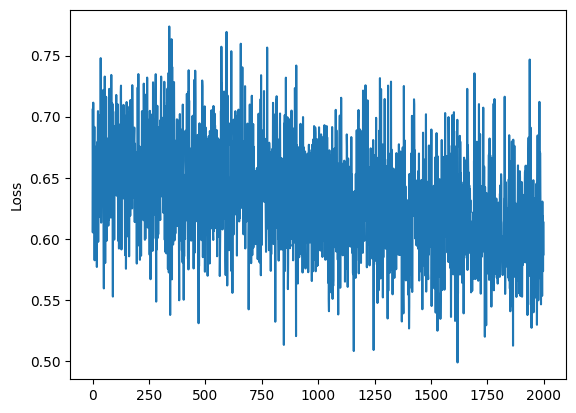

In [10]:
from matplotlib import pyplot as plt


plt.figure(figsize=(6, 6))

plt.plot(range(len(rewards)), rewards)
plt.ylabel("Rewards")
plt.show()

plt.plot(range(len(total_loss)), total_loss, label="Loss")
plt.ylabel("Loss")
plt.show()

In [16]:
# agent.model.load_weights("models/DQN_ep#5139_eps#0.3217_rw#142.8.h5")

env.close()
env = make_env(return_full_state=True)
state = env.reset()

rewards = 0
done = False

frames = []
start = time.time()
while not done:
    action = agent.boltzman_sampling(state)
    # action = agent.epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)

    rewards += reward
    print("\r{}, {}".format(rewards, reward), end="")

    obs = env.render("rgb_array")
    frames.append(obs)

    if len(frames) > 5000:
        break

fps = len(frames) / (time.time() - start)
print(f"\nFPS: {fps}")

-55.40000000000011, -9.111
FPS: 93.33357547836505


In [17]:
import PIL

import os


image_path = os.path.join("rl videos", f"snake_dqn_{n_iterations}_iters.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)